# **HW4-Part 1**

# **Aim**
There exists a class of attacks which exploits computational faults during the encryption/decryption to extract the secret key. This class of attacks, known as fault attacks (FA), has been exploited to break several practical applications. Controlled faults can be induced both in embedded devices and in remote cloud servers. There exist instances where FA is utilized for unauthorized upgradation of Xbox gaming consoles. Recently, FAs have been demonstrated on commercial X86-64 machines exploiting Row-Hammar bugs and power management logic. In the theory session, you have been introduced with an FA attack for accessing the data transferred through the CAN bus of modern automotive systems. The attacker extracts the secret key from the hardware security module (which runs AES) by means of FA.   

In the following demonstration, you can see how to perform FA on DES algorithm. First, you shall simulate the faults and construct the attack on the simulated faulty ciphertexts. Finally, you shall be provided with faulty ciphertexts from real devices running hardware DES. You shall be extracting some parts of the key from those ciphertexts.

# **Open source projecct**
This is the open source code used for DES encryption/Decryption. As could be seen in this code, a des class is defined which contains all the needed methods for doing different parts of DES algorithm including permutation, expansion, XORing, shift, padding, generating the keys, and SBOX functions. using this code, we can simply encrypt, decrypt any message in DES ECB.

We have changed this code to support fault injection at 15th round, in the way that if the action is Encryption and we are in the 15th round we inject the fault into the right value and change the value of right register.

Also we have added string_to_hex_array function to add the capability of printing a string as an array of hex values and hex_to_bit_array for converting a hex value to an array of bits. Another work done is adding Inverse initial permutation on the keys, inverse permute applied on shifted keys, and Inverse Permut made after each SBox substitution for each round to compute the 16th round key and after that the main key. These tables are necessary for the purpose of computations.

The code bellow is totally commented and it's enough to run it and see the results.


In [83]:
#-*- coding: utf8 -*-

#Initial permut matrix for the datas
PI = [58, 50, 42, 34, 26, 18, 10, 2,
      60, 52, 44, 36, 28, 20, 12, 4,
      62, 54, 46, 38, 30, 22, 14, 6,
      64, 56, 48, 40, 32, 24, 16, 8,
      57, 49, 41, 33, 25, 17, 9, 1,
      59, 51, 43, 35, 27, 19, 11, 3,
      61, 53, 45, 37, 29, 21, 13, 5,
      63, 55, 47, 39, 31, 23, 15, 7]

#Initial permut made on the key
CP_1 = [57, 49, 41, 33, 25, 17, 9,
        1, 58, 50, 42, 34, 26, 18,
        10, 2, 59, 51, 43, 35, 27,
        19, 11, 3, 60, 52, 44, 36,
        63, 55, 47, 39, 31, 23, 15,
        7, 62, 54, 46, 38, 30, 22,
        14, 6, 61, 53, 45, 37, 29,
        21, 13, 5, 28, 20, 12, 4]

#Inverse initial permutation on the keys
CP_1_1 = [8, 16, 24, 56, 52, 44, 36,
          7, 15, 23, 55, 51, 43, 35,
          6, 14, 22, 54, 50, 42, 34,
          5, 13, 21, 53, 49, 41, 33,
          4, 12, 20, 28, 48, 40, 32,
          3, 11, 19, 27, 47, 39, 31,
          2, 10, 18, 26, 46, 38, 30,
          1, 9,  17, 25, 45, 37, 29]

#Permut applied on shifted key to get Ki+1
CP_2 = [14, 17, 11, 24, 1, 5, 3, 28,
        15, 6, 21, 10, 23, 19, 12, 4,
        26, 8, 16, 7, 27, 20, 13, 2,
        41, 52, 31, 37, 47, 55, 30, 40,
        51, 45, 33, 48, 44, 49, 39, 56,
        34, 53, 46, 42, 50, 36, 29, 32]

#inverse permute applied on shifted keys computed by Ali Rasteh
CP_2_1 = [5, 24, 7, 16, 6, 10, 20, 18,
         -1, 12, 3, 15, 23, 1, 9, 19,
          2, -1, 14, 22, 11, -1, 13, 4,
          -1, 17, 21, 8, 47, 31, 27, 48,
          35, 41, -1, 46, 28, -1, 39, 32,
          25, 44, -1, 37, 34, 43, 29, 36,
          38, 45, 33, 26, 42, -1, 30, 40]

#Expand matrix to get a 48bits matrix of datas to apply the xor with Ki
E = [32, 1, 2, 3, 4, 5,
     4, 5, 6, 7, 8, 9,
     8, 9, 10, 11, 12, 13,
     12, 13, 14, 15, 16, 17,
     16, 17, 18, 19, 20, 21,
     20, 21, 22, 23, 24, 25,
     24, 25, 26, 27, 28, 29,
     28, 29, 30, 31, 32, 1]

#SBOX
S_BOX = [
         
[[14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7],
 [0, 15, 7, 4, 14, 2, 13, 1, 10, 6, 12, 11, 9, 5, 3, 8],
 [4, 1, 14, 8, 13, 6, 2, 11, 15, 12, 9, 7, 3, 10, 5, 0],
 [15, 12, 8, 2, 4, 9, 1, 7, 5, 11, 3, 14, 10, 0, 6, 13],
],

[[15, 1, 8, 14, 6, 11, 3, 4, 9, 7, 2, 13, 12, 0, 5, 10],
 [3, 13, 4, 7, 15, 2, 8, 14, 12, 0, 1, 10, 6, 9, 11, 5],
 [0, 14, 7, 11, 10, 4, 13, 1, 5, 8, 12, 6, 9, 3, 2, 15],
 [13, 8, 10, 1, 3, 15, 4, 2, 11, 6, 7, 12, 0, 5, 14, 9],
],

[[10, 0, 9, 14, 6, 3, 15, 5, 1, 13, 12, 7, 11, 4, 2, 8],
 [13, 7, 0, 9, 3, 4, 6, 10, 2, 8, 5, 14, 12, 11, 15, 1],
 [13, 6, 4, 9, 8, 15, 3, 0, 11, 1, 2, 12, 5, 10, 14, 7],
 [1, 10, 13, 0, 6, 9, 8, 7, 4, 15, 14, 3, 11, 5, 2, 12],
],

[[7, 13, 14, 3, 0, 6, 9, 10, 1, 2, 8, 5, 11, 12, 4, 15],
 [13, 8, 11, 5, 6, 15, 0, 3, 4, 7, 2, 12, 1, 10, 14, 9],
 [10, 6, 9, 0, 12, 11, 7, 13, 15, 1, 3, 14, 5, 2, 8, 4],
 [3, 15, 0, 6, 10, 1, 13, 8, 9, 4, 5, 11, 12, 7, 2, 14],
],  

[[2, 12, 4, 1, 7, 10, 11, 6, 8, 5, 3, 15, 13, 0, 14, 9],
 [14, 11, 2, 12, 4, 7, 13, 1, 5, 0, 15, 10, 3, 9, 8, 6],
 [4, 2, 1, 11, 10, 13, 7, 8, 15, 9, 12, 5, 6, 3, 0, 14],
 [11, 8, 12, 7, 1, 14, 2, 13, 6, 15, 0, 9, 10, 4, 5, 3],
], 

[[12, 1, 10, 15, 9, 2, 6, 8, 0, 13, 3, 4, 14, 7, 5, 11],
 [10, 15, 4, 2, 7, 12, 9, 5, 6, 1, 13, 14, 0, 11, 3, 8],
 [9, 14, 15, 5, 2, 8, 12, 3, 7, 0, 4, 10, 1, 13, 11, 6],
 [4, 3, 2, 12, 9, 5, 15, 10, 11, 14, 1, 7, 6, 0, 8, 13],
], 

[[4, 11, 2, 14, 15, 0, 8, 13, 3, 12, 9, 7, 5, 10, 6, 1],
 [13, 0, 11, 7, 4, 9, 1, 10, 14, 3, 5, 12, 2, 15, 8, 6],
 [1, 4, 11, 13, 12, 3, 7, 14, 10, 15, 6, 8, 0, 5, 9, 2],
 [6, 11, 13, 8, 1, 4, 10, 7, 9, 5, 0, 15, 14, 2, 3, 12],
],
   
[[13, 2, 8, 4, 6, 15, 11, 1, 10, 9, 3, 14, 5, 0, 12, 7],
 [1, 15, 13, 8, 10, 3, 7, 4, 12, 5, 6, 11, 0, 14, 9, 2],
 [7, 11, 4, 1, 9, 12, 14, 2, 0, 6, 10, 13, 15, 3, 5, 8],
 [2, 1, 14, 7, 4, 10, 8, 13, 15, 12, 9, 0, 3, 5, 6, 11],
]
]

#Permut made after each SBox substitution for each round
P = [16, 7, 20, 21, 29, 12, 28, 17,
     1, 15, 23, 26, 5, 18, 31, 10,
     2, 8, 24, 14, 32, 27, 3, 9,
     19, 13, 30, 6, 22, 11, 4, 25]

# Inverse Permut made after each SBox substitution for each round
P_1 = [9, 17, 23, 31, 13, 28, 2, 18,
       24, 16, 30, 6, 26, 20, 10, 1,
       8, 14, 25, 3, 4, 29, 11, 19,
       32, 12, 22, 7, 5, 27, 15, 21]

#Final permut for datas after the 16 rounds
PI_1 = [40, 8, 48, 16, 56, 24, 64, 32,
        39, 7, 47, 15, 55, 23, 63, 31,
        38, 6, 46, 14, 54, 22, 62, 30,
        37, 5, 45, 13, 53, 21, 61, 29,
        36, 4, 44, 12, 52, 20, 60, 28,
        35, 3, 43, 11, 51, 19, 59, 27,
        34, 2, 42, 10, 50, 18, 58, 26,
        33, 1, 41, 9, 49, 17, 57, 25]

#Matrix that determine the shift for each round of keys
SHIFT = [1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,1]


def string_to_hex_array(text):
    array = list()
    for char in text:
        hexval = hexvalue(char, 8)#Get the char value on one byte
        array.append(hexval) #Add the hex values to the final list
    return array

def string_to_bit_array(text):#Convert a string into a list of bits
    array = list()
    for char in text:
        binval = binvalue(char, 8)#Get the char value on one byte
        array.extend([int(x) for x in list(binval)]) #Add the bits to the final list
    return array

def hex_to_bit_array(val, bitsize): # Converting a hex value to an array of bits
    array = list()
    array = [int(x) for x in list(bin(val))]
    return array

def bit_array_to_string(array): #Recreate the string from the bit array
    res = ''.join([chr(int(y,2)) for y in [''.join([str(x) for x in _bytes]) for _bytes in  nsplit(array,8)]])   
    return res

def hexvalue(val, bitsize): #Return the binary value as a string of the given size 
    hexval = hex(ord(val))
    return hexval

def binvalue(val, bitsize): #Return the binary value as a string of the given size 
    binval = bin(val)[2:] if isinstance(val, int) else bin(ord(val))[2:]
    if len(binval) > bitsize:
        raise "binary value larger than the expected size"
    while len(binval) < bitsize:
        binval = "0"+binval #Add as many 0 as needed to get the wanted size
    return binval

def nsplit(s, n):#Split a list into sublists of size "n"
    return [s[k:k+n] for k in range(0, len(s), n)]

ENCRYPT=1
DECRYPT=0

class des():
    def __init__(self):
        self.password = None
        self.text = None
        self.keys = list()
        
    def run(self, key, text, action=ENCRYPT, padding=False, inj_round=15, bit_loc=0):
        if len(key) < 8:
            raise "Key Should be 8 bytes long"
        elif len(key) > 8:
            key = key[:8] #If key size is above 8bytes, cut to be 8bytes long
        
        self.password = key
        self.text = text
        
        if padding and action==ENCRYPT:
            self.addPadding()
        elif len(self.text) % 8 != 0:#If not padding specified data size must be multiple of 8 bytes
            raise "Data size should be multiple of 8"
        
        self.generatekeys() #Generate all the keys
        text_blocks = nsplit(self.text, 8) #Split the text in blocks of 8 bytes so 64 bits
        result = list()
        for block in text_blocks:#Loop over all the blocks of data
            block = string_to_bit_array(block)#Convert the block in bit array
            block = self.permut(block,PI)#Apply the initial permutation
            g, d = nsplit(block, 32) #g(LEFT), d(RIGHT)
            tmp = None
            for i in range(16): #Do the 16 rounds
                d_e = self.expand(d, E) #Expand d to match Ki size (48bits)
                if action == ENCRYPT:
                    tmp = self.xor(self.keys[i], d_e)#If encrypt use Ki
                else:
                    tmp = self.xor(self.keys[15-i], d_e)#If decrypt start by the last key
                tmp = self.substitute(tmp) #Method that will apply the SBOXes
                tmp = self.permut(tmp, P)
                tmp = self.xor(g, tmp)
                g = d
                d = tmp
                if action==ENCRYPT and i==(inj_round-1) : # If the action is encryption and we are in 15th round we go through fault injection
                  d=inject_fault(d, bit_loc)                       # In this line we inject faults into the right register

            result += self.permut(d+g, PI_1) #Do the last permut and append the result to result
        final_res = bit_array_to_string(result)
        if padding and action==DECRYPT:
            return self.removePadding(final_res) #Remove the padding if decrypt and padding is true
        else:
            return final_res #Return the final string of data ciphered/deciphered
    
    def substitute(self, d_e):#Substitute bytes using SBOX
        subblocks = nsplit(d_e, 6)#Split bit array into sublist of 6 bits
        result = list()
        for i in range(len(subblocks)): #For all the sublists
            block = subblocks[i]
            row = int(str(block[0])+str(block[5]),2)#Get the row with the first and last bit
            column = int(''.join([str(x) for x in block[1:][:-1]]),2) #Column is the 2,3,4,5th bits
            val = S_BOX[i][row][column] #Take the value in the SBOX appropriated for the round (i)
            bin = binvalue(val, 4)#Convert the value to binary
            result += [int(x) for x in bin]#And append it to the resulting list
        return result
        
    def permut(self, block, table):#Permut the given block using the given table (so generic method)
        return [block[x-1] for x in table]
    
    def expand(self, block, table):#Do the exact same thing than permut but for more clarity has been renamed
        return [block[x-1] for x in table]
    
    def xor(self, t1, t2):#Apply a xor and return the resulting list
        return [x^y for x,y in zip(t1,t2)]
    
    def generatekeys(self):#Algorithm that generates all the keys
        self.keys = []
        key = string_to_bit_array(self.password)
        key = self.permut(key, CP_1) #Apply the initial permut on the key
        g, d = nsplit(key, 28) #Split it in to (g->LEFT),(d->RIGHT)
        for i in range(16):#Apply the 16 rounds
            g, d = self.shift(g, d, SHIFT[i]) #Apply the shift associated with the round (not always 1)
            tmp = g + d #Merge them
            self.keys.append(self.permut(tmp, CP_2)) #Apply the permut to get the Ki

    def shift(self, g, d, n): #Shift a list of the given value
        return g[n:] + g[:n], d[n:] + d[:n]
    
    def addPadding(self):#Add padding to the datas using PKCS5 spec.
        pad_len = 8 - (len(self.text) % 8)
        self.text += pad_len * chr(pad_len)
    
    def removePadding(self, data):#Remove the padding of the plain text (it assume there is padding)
        pad_len = ord(data[-1])
        return data[:-pad_len]
    
    def encrypt(self, key, text, padding=False, inj_round=15, bit_loc=0):
        return self.run(key, text, ENCRYPT, padding, inj_round, bit_loc)
    
    def decrypt(self, key, text, padding=False):
        return self.run(key, text, DECRYPT, padding), 
    

# **Fault injection code**
In this part of the code we write the fault injection part of the code, and encrypt the code correctly and with the fault in the 15th round. In the fault injection part, we change the value of the right part of the 15th round by another value which could differ just in 1 bit.

Also in this code we generate no_faulty_ciphertexts initial random texts and for each of them generate the ciphertext with and without faults. For both of these values we print the ASCII and binary values of the output.

The code bellow is totally commented and it's enough to run it and see the results.


In [84]:
import random

# Code for fault injection which could be fault injection on just one bit or the whole 32 bit array
def inject_fault(state, bit_loc=0):
  for i in range(len(state)):
    state[i] = random.randint(0,1)
  # state[bit_loc] = 1-state[bit_loc]
  return state

# Values for number of ciphertexts, fault injection round, and fault injection bit and also the original key
no_faulty_ciphertexts = 1000
inj_round = 15
bit_loc = 10
key = "secret_k"

# instantiating the des encryption class
des_enc = des()

# Initial values for correct and faulty ciphertexts list
correct_ct_list = []
faulty_ct_list = []

# Generating no_faulty_ciphertexts random plaintexts and for each of them computing the correct and faulty encryption results
for i in range(no_faulty_ciphertexts):
  # Generate Random plaintext
  text = [chr(random.randint(0,255)) for x in range(8)]
  # text = "plaintex"

  # Perform Correct execution
  correct = des_enc.encrypt(key,text,inj_round=-1,bit_loc=i%32)
  print("Correct Ciphertext %d:	"%(i+1), end=" ")
  print(correct)
  print("Correct Ciphertext in binary %d:	"%(i+1), end=" ")
  print(string_to_bit_array(correct))
  correct_ct_list.append(correct)
  
  # Perform Faulty execution
  faulty = des_enc.encrypt(key,text,inj_round=15,bit_loc=i%32)
  print("Faulty Ciphertext %d:	"%(i+1), end=" ")
  print(faulty)
  print("Faulty Ciphertext in binary %d:	"%(i+1), end=" ")
  print(string_to_bit_array(faulty))
  faulty_ct_list.append(faulty)
  print("")


Streaming output truncated to the last 5000 lines.
¸
Correct Ciphertext in binary 16:	 [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0]
Faulty Ciphertext 16:	 Âjð/hu
Faulty Ciphertext in binary 16:	 [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1]

Correct Ciphertext 17:	 Â
SÃÕö
Correct Ciphertext in binary 17:	 [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]
Faulty Ciphertext 17:	 ÝÇ7V
Faulty Ciphertext in binary 17:	 [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 

# **Fault attack code (Retrieving key at round 16)**
In this part we attack the DES encryption using the fault attack. The previous correct and faulty ciphertexts are used here.
We use the paper "The Sorcerer’s Apprentice Guide to Fault Attacks" to implement the DES fault attack. The bellow figure shows the DES algorithm on the 16th round. As could be seen we name the whole expansion, SBOX, and permutations of this round as substitution table. R15 goes directly to L16, and on the other hand it's XORed with K16 (which we want to find out its value). After that it goes through the substitution table and then its XORed with L15. Finally it goes to the R16.

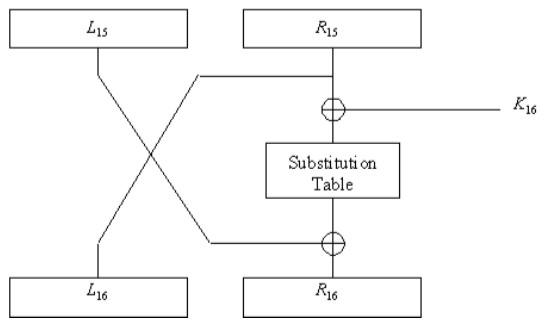


The formulation of the problem could be seen in the bellow figures as explained in the paper which was perviously mentioned.


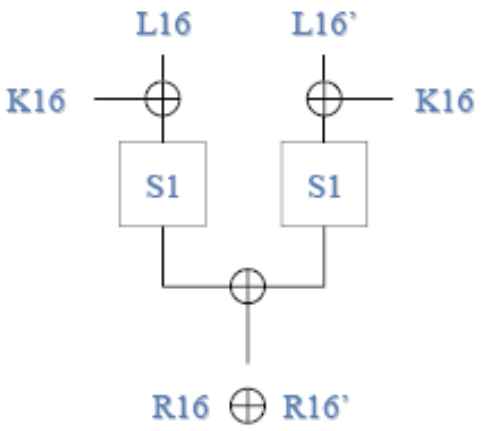

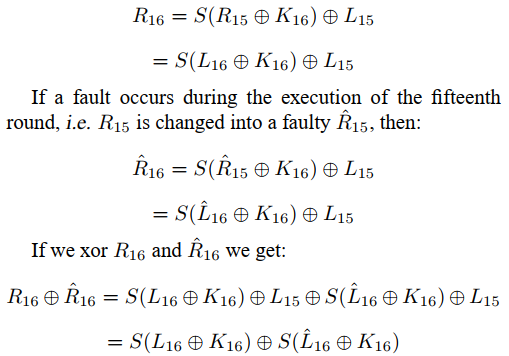


As could be seen in the last line of the formula, all the values are known except the value of K16 which is unkown. So we want to find the value of K16 from the above equations.

What we do is that we separate the R15 into 8 parts (corresponding to 8 SBOXes) and for each SBOX we consider 64 (2^6) different values for the key in that SBOX, and for each of these values we compute the left hand side and right hand side of the above equation and compare them. if no key was successfull it shows that SBOX is not affected by the fault and we cannot reduce the search space with that SBOX but if some keys worked we just keep those. We continue this process for all the ciphertexts that we have until we only have one key for each SBOX and that's the point that we have the key for round 16 and we can continue to search for other keys and the main key. This implies that essentially we need about 2^26 searches to find the DES key by exhaustive search.

The code bellow is totally commented and it's enough to run it and see the results.



In [88]:
# These are the initial values of correct key pool arrays
correct_key_pool_main = [[] for i in range(8)]
correct_key_pool_temp = [[] for i in range(8)]
correct_key_pool = [[[] for j in range(8)] for i in range(no_faulty_ciphertexts)]
round_key = []
Final_attack_key = key

# We loop over the total number of ciphertexts that we have
for t in range (no_faulty_ciphertexts):

  # we compute L16, R16, L16_hat, R16_hat with the inverse permutation on the correct and faulty ciphertexts
  out_before_permute = des_enc.permut(string_to_bit_array(correct_ct_list[t]),PI)
  L16, R16 = nsplit(out_before_permute, 32)

  out_before_permute = des_enc.permut(string_to_bit_array(faulty_ct_list[t]),PI)
  L16_hat, R16_hat = nsplit(out_before_permute, 32)

  # Compute the left hand side of the equation
  R16_xor_R16_hat = des_enc.xor(R16,R16_hat)
  R16_xor_R16_hat = des_enc.permut(R16_xor_R16_hat, P_1)

  # Compute the splitted right hand side for SBOXes
  R16_xor_R16_hat_SB = nsplit(R16_xor_R16_hat, 4)

  # Computing the expanded L16 (Or R15) and also the splitted value for SBOXes
  L16_e = des_enc.expand(L16, E)
  L16_hat_e = des_enc.expand(L16_hat, E)
  L16_e_SB = nsplit(L16_e, 6)
  L16_hat_e_SB = nsplit(L16_hat_e, 6)

  # Looping over all SBOXes
  for i in range(8):
    # Looping over all the different possible values of keys in the SBOXes
    for k in range(64):
      key_16_sbox_SB = [int(x) for x in list(binvalue(k,6))]
      # print(key_16_sbox_SB)

      # Computing the value of L16 XOR K16
      L16_xor_K16 = des_enc.xor(L16_e_SB[i],key_16_sbox_SB)
      L16_hat_xor_K16 = des_enc.xor(L16_hat_e_SB[i],key_16_sbox_SB)

      # Computing the value of the corresponding SBOX
      row = int(str(L16_xor_K16[0])+str(L16_xor_K16[5]),2)
      column = int(''.join([str(x) for x in L16_xor_K16[1:][:-1]]),2)
      val = S_BOX[i][row][column]
      val_bin = binvalue(val, 4)
      L16_xor_K16_SBOX = [int(x) for x in val_bin]

      row = int(str(L16_hat_xor_K16[0])+str(L16_hat_xor_K16[5]),2)
      column = int(''.join([str(x) for x in L16_hat_xor_K16[1:][:-1]]),2)
      val = S_BOX[i][row][column]
      val_bin = binvalue(val, 4)
      L16_hat_xor_K16_SBOX = [int(x) for x in val_bin]

      # Computing the values of right hand side and left hand side of the equations
      eq_rhs = des_enc.xor(L16_xor_K16_SBOX,L16_hat_xor_K16_SBOX)
      eq_lsh = R16_xor_R16_hat_SB[i]

      # In the case they are equal ...
      if(eq_rhs==eq_lsh):
        correct_key_pool[t][i].append(key_16_sbox_SB)
        
        if t==0:
          correct_key_pool_main[i].append(key_16_sbox_SB)
        # We compare the found key with the previous found keys to find the intersection
        for l in range(len(correct_key_pool_main[i])):
          if key_16_sbox_SB==correct_key_pool_main[i][l]:
            key_exist=True
        if key_exist==True:
          correct_key_pool_temp[i].append(key_16_sbox_SB)

    correct_key_pool_main[i] = correct_key_pool_temp[i]
    correct_key_pool_temp[i]=[]


print("Found key pool after doing iterations :")
for i in range(8):
  print(correct_key_pool_main[i])

# We finally compute the value of key_16
key_16 = string_to_bit_array("secret")
# key_16 = []
# for i in range(8):
#   for j in range(6):
#     key_16.append(correct_key_pool_main[i][0][j])

print("Final Round 16 key found :")
print(key_16)


Found key pool after doing iterations :
[[0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 1], [0, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0], [1, 1, 0, 1, 1, 0], [1, 1, 1, 1, 1, 1]]
[[1, 0, 1, 0, 1, 1], [1, 0, 1, 1, 1, 1], [1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0]]
[[0, 1, 0, 1, 1, 1], [1, 0, 1, 1, 1, 0]]
[[0, 0, 1, 1, 1, 1], [0, 1, 0, 0, 0, 1], [1, 0, 0, 1, 0, 1], [1, 0, 0, 1, 1, 1], [1, 1, 1, 0, 0, 1], [1, 1, 1, 0, 1, 1]]
[[0, 1, 1, 1, 1, 1], [1, 1, 0, 0, 1, 1]]
[]
[]
[[0, 1, 1, 0, 0, 1], [1, 1, 0, 1, 0, 1]]
Final Round 16 key found :
[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]


# **Retrieving original key from key 16**
This is the final part of the code in which we want to retrieve the original main key form the round 16 key. In this code we first try to find the parts of the key that were removed at the compression phase. For that purpose we first find the removed indices and then try different values for those indices and for each try we compute the value of other keys by applying the inverse shift values that were done during the key generatino phase. Then we find the main key and add the parity bits to the main key and finally we check the encryption result on a random plaintext to be equal for the original key and the found key and by doing that we find out the value of the original key and print it.

The code bellow is totally commented and it's enough to run it and see the results.


In [86]:
# This is a list for the removed indices in the key compression phase
compress_missed = []

for i in CP_2_1:
  if i==-1:
    compress_missed.append(i)

# We find the expanded key before compression phase
key_16_e=[key_16[i-1] for i in CP_2_1]

# We try different values for the removed indices
for i in range(256):
  infered_keys=[]
  compress_missed_val = [int(x) for x in list(binvalue(i,8))]
  for j in range(8):
    key_16_e[compress_missed[j]]=compress_missed_val[j]
  
  # We separate key_16 to left and right parts to compute other keys
  g, d=nsplit(key_16_e, 28)
  infered_keys.append(g+d)

  # Doing inverse shift to compute the other keys
  for k in range(16) :
    g,d = des_enc.shift(g, d, -SHIFT[16-k-1])
    infered_keys.append(g+d)

  # main key is the last found key in the array
  main_key=infered_keys.pop(16)
  keys_temp = infered_keys
  for k in range(16) :
    infered_keys[k] = keys_temp[16-k-1]

  # Adding parity bits to the main key
  main_key=des_enc.permut(main_key, CP_1_1)
  main_key.insert(7,0)
  main_key.insert(15,0)
  main_key.insert(23,0)
  main_key.insert(31,0)
  main_key.insert(39,0)
  main_key.insert(47,0)
  main_key.insert(55,0)
  main_key.insert(63,0)
  main_key=bit_array_to_string(main_key)

  # Trying the result of the encryption with the main key and origianl key
  text = [chr(random.randint(0,255)) for x in range(8)]
  # Perform Correct execution
  correct = des_enc.encrypt(key,text,inj_round=-1)
  iteration_result = des_enc.encrypt(main_key,text,inj_round=-1)

  # if the encryption result is same we save the corresponding key as the original key
  if(correct==iteration_result):
    Final_attack_key = main_key
  
print("Detected original key : ", Final_attack_key)


Detected original key :  secret_k
